In [8]:
# Import required modules
import warnings
import os
import optuna
import numpy as np
import pandas as pd
import torch
from darts.utils.likelihood_models.base import LikelihoodType
from darts.metrics import mape, rmse, mse, mae, r2_score,smape
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape
import holidays
import torch
import torchmetrics
from torchmetrics.collections import MetricCollection
from darts.models import TFTModel
from darts.utils.likelihood_models import QuantileRegression
import torch.optim as optim
torch.set_float32_matmul_precision('medium')
device0 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings("ignore")
print(torch.cuda.is_available())


True


In [9]:
def read_load_data():
    base_dir = os.getcwd()
    load_file_path = os.path.join(base_dir, 'processed_loadUTC_data.csv')
    load_data = pd.read_csv(load_file_path)
    load_data.rename(columns={
        "Actual Total Load [MW] - BZN|SE4": "Actual Load",
        "Time (UTC)": "Time"
    }, inplace=True)
    load_data['Time'] = pd.to_datetime(load_data['Time'].str.split(' - ').str[0], format='%d.%m.%Y %H:%M')
    load_data.set_index('Time', inplace=True)
    load_data.drop('Day-ahead Total Load Forecast [MW] - BZN|SE4', axis=1, inplace=True)
    return load_data

data = read_load_data()

In [10]:
def import_weather_data(df, solar_power=False):
    base_dir = os.getcwd()
    temperature_file_path = os.path.join(base_dir, 'weighted_avg_temp.csv')
    humidity_file_path = os.path.join(base_dir, 'weighted_avg_humidity.csv')
    solar_file_path = os.path.join(base_dir, 'weighted_avg_solar.csv')
    avg_temperature_data = pd.read_csv(temperature_file_path)
    avg_humidity_data = pd.read_csv(humidity_file_path)
    avg_solar_data = pd.read_csv(solar_file_path)
    df['Temperature'] = avg_temperature_data['weighted_avg'].values
    df['Humidity'] = avg_humidity_data['weighted_avg'].values
    df['Solar_Irrad'] = avg_solar_data['weighted_avg'].values

    if solar_power:
        tot_installed_capacity = np.array([
            2.52, 5.04, 7.56, 10.08, 12.6, 18.6, 29.2, 41.53, 69.55, 85
        ]) * 1e6
        installed_capacity_house = 10 * 1e3
        n_installations = tot_installed_capacity / installed_capacity_house
        panel_per_house = 24
        area_per_panel = 2

        years = np.arange(2015, 2025)
        total_area_panels = n_installations * panel_per_house * area_per_panel
        area_by_year = dict(zip(years, total_area_panels))

        panel_efficiency = 0.2
        df['year'] = df.index.year
        df['Solar'] = df['Solar_Irrad'] * df['year'].map(area_by_year) * panel_efficiency
        df.drop(columns='year', inplace=True)
    else:
        df['Solar'] = df['Solar_Irrad']
    df.drop(columns='Solar_Irrad', inplace=True)
    return df


data = import_weather_data(data, solar_power=True)

In [11]:
def import_swedish_holidays(df):
    years = np.arange(2015, 2025)
    raw_holidays = []
    for date, name in sorted(holidays.Sweden(years=years).items()):
        if name != "Söndag":
            raw_holidays.append(date)
        raw_holidays.append(date)
    holiday_dates = set(raw_holidays)
    df['is_holiday'] = pd.Series(df.index.date).isin(holiday_dates).astype(int).values
    return df


data = import_swedish_holidays(data)

In [12]:
def create_date_features(df):
    df['hour'] = df.index.hour
    return df


data = create_date_features(data)

In [13]:
def add_noise_to_covariates(df, noise_level=0.05):
    stochastic_cols = ["Temperature", "Humidity", "Solar"]
    df_noisy = df.copy()
    for col in stochastic_cols:
        if col in df_noisy.columns:
            if col == "Solar":
                base = df_noisy[col].values
                noise = np.random.normal(0, noise_level * base)
                df_noisy[col] += noise
                df_noisy[col] = df_noisy[col].clip(lower=0)
            else:
                std = df_noisy[col].std()
                noise = np.random.normal(0, noise_level * std, size=len(df_noisy))
                df_noisy[col] += noise
    return df_noisy


#Retain the original data without noise
clean_future_data = data.copy()
future_data = add_noise_to_covariates(data)

In [14]:
def create_lag_features(df, load="Actual Load", nan=False):
    df = df.copy()
    for lag in [1, 2, 3, 6, 12, 24]:
        df[f'lag_temp_{lag}'] = df["Temperature"].shift(lag)
        df[f'lag_humid_{lag}'] = df["Humidity"].shift(lag)
        df[f'lag_solar_{lag}'] = df["Solar"].shift(lag)
        if lag <= 3:
            df[f'lag_hour_{lag}'] = df["hour"].shift(lag)
        if nan:
            df[f'lag_{lag}'] = np.nan
        else:
            df[f'lag_{lag}'] = df[load].shift(lag)
    for day in range(2, 8):
        lag = day * 24
        if nan:
            df[f'lag_{lag}'] = np.nan
        else:
            df[f'lag_{lag}'] = df[load].shift(lag)
    return df


data = create_lag_features(data)
data = data.dropna() # first week in 2015 dropped to enable lag features
#drop the lag_1 column
data.drop(columns=['lag_1','lag_2','lag_3','lag_6','lag_12','lag_hour_1','lag_hour_2','lag_hour_1','lag_hour_3',], inplace=True)
#future_data = create_lag_features(future_data, nan=True)
future_data = future_data[future_data.index >= data.index.min()]


In [15]:
# drop all the data before 2022
data = data[data.index >= "2022-01-01"]

future_data = future_data[future_data.index >= "2022-01-01"]
clean_future_data = clean_future_data[clean_future_data.index >= "2022-01-01"]
#print(future_data.index)  # Should be DatetimeIndex

series = TimeSeries.from_dataframe(data, value_cols="Actual Load")
#print(series.columns.tolist())   # Lists all column names


In [16]:
# Split dates for training and validation sets
training_cutoff = pd.Timestamp("2023-12-31 23:00:00")
train_cov_cutoff = pd.Timestamp("2024-01-01 00:00:00")
validating_cutoff = pd.Timestamp("2024-12-22 23:00:00")

In [17]:
# Split after training_cutoff
train, rest = series.split_after(training_cutoff)

# Split the remaining data after validating_cutoff
val, test = rest.split_after(validating_cutoff)
print('Train Series:', train.start_time(), train.end_time())
print('Val Series:', val.start_time(), val.end_time())
print('Test Series:', test.start_time(), test.end_time())

# Normalize the time series (scaling)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)
test_transformed = transformer.transform(test)

Train Series: 2022-01-01 00:00:00 2023-12-31 23:00:00
Val Series: 2024-01-01 00:00:00 2024-12-22 23:00:00
Test Series: 2024-12-23 00:00:00 2024-12-31 23:00:00


In [18]:
# Select all columns except 'Actual Load'
value_cols = [col for col in data.columns if col != "Actual Load"]

# Create the TimeSeries (assuming index is datetime or time_col is defined)
past_covariates = TimeSeries.from_dataframe(data, value_cols=value_cols)
# Normalize historical covariates
scaler_covs = Scaler()
scaler_covs.fit(past_covariates[:training_cutoff])
past_covariates_transformed = scaler_covs.transform(past_covariates)
# Use same cutoff points for consistency
train_past_covs, rest_past_covs = past_covariates_transformed.split_after(training_cutoff)
val_past_covs, test_past_covs  = rest_past_covs.split_after(validating_cutoff)
last24_ =train_past_covs[-24:]
val_past_covs = last24_.append(val_past_covs)

print(train_past_covs.start_time(), train_past_covs.end_time())
print(val_past_covs.start_time(), val_past_covs.end_time())

2022-01-01 00:00:00 2023-12-31 23:00:00
2023-12-31 00:00:00 2024-12-22 23:00:00


In [19]:
# Apply the same approach for future covariates:
# Right now we are using the same data as past covariates, in practice the load lags should not be used

# Drop "Actual Load" from value columns
value_cols = [col for col in future_data.columns if col != "Actual Load"]

# Create the TimeSeries
future_covariates = TimeSeries.from_dataframe(future_data, value_cols=value_cols) 
clean_future_cov = TimeSeries.from_dataframe(clean_future_data, value_cols=value_cols)
clean_train_future_covs, rest_future_covs = clean_future_cov.split_after(training_cutoff)
noisy_data, rest_data = future_covariates.split_after(training_cutoff) 
print(clean_train_future_covs.end_time())
print(rest_data.start_time())
future_covariates = clean_train_future_covs.append(rest_data)

# Apply the same approach for future covariates:
scaler_covs_future = Scaler()
scaler_covs_future.fit(future_covariates[:training_cutoff])  # Fit on training data

# Transform all future covariates
future_covariates_transformed = scaler_covs_future.transform(future_covariates)

# Split transformed future covariates into training, validation, and test sets
train_future_covs, rest_future_covs = future_covariates_transformed.split_after(training_cutoff)
val_future_covs, test_future_covs = rest_future_covs.split_after(validating_cutoff)

last24_ =train_future_covs[-24:]

val_future_covs = last24_.append(val_future_covs)
print(val_future_covs.start_time(), val_future_covs.end_time())

#add the first 24 hours of val future covariates to the end of the train future covariates
next48 = val_future_covs[:48]
next24 = next48[-24:]
train_future_covs = train_future_covs.append(next24)
print(train_future_covs.start_time(), train_future_covs.end_time())



2023-12-31 23:00:00
2024-01-01 00:00:00
2023-12-31 00:00:00 2024-12-22 23:00:00
2022-01-01 00:00:00 2024-01-01 23:00:00


In [20]:
# Define quantiles for QuantileRegression
quantiles = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99,]

In [21]:
def encode_year(index):
    return pd.Series(index.year, index=index)

#Define callback function

from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over

from pytorch_lightning.callbacks import Callback
from optuna.exceptions import TrialPruned

class CustomPyTorchLightningPruningCallback(Callback):
    def __init__(self, trial, monitor="val_loss"):
        self._trial = trial
        self._monitor = monitor

    def on_validation_end(self, trainer, pl_module):
        logs = trainer.callback_metrics
        current_score = logs.get(self._monitor)
        if current_score is None:
            return
        self._trial.report(current_score, step=trainer.global_step)
        if self._trial.should_prune():
            message = f"Trial was pruned at step {trainer.global_step}."
            raise optuna.TrialPruned(message)


def objective(trial):
    optuna_callback = CustomPyTorchLightningPruningCallback(trial, monitor="val_loss")
    early_stopper = EarlyStopping(
    monitor="val_loss",  # Using train_loss instead of val_loss might not be a good idea
    min_delta=0.005,
    patience=3,
    verbose=True
    )
    # Sample hyperparameters
    hidden_size = trial.suggest_categorical("hidden_size", [12, 24, 32])
    lstm_layers = trial.suggest_int("lstm_layers", 1, 4)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    input_chunk_length = trial.suggest_categorical("input_chunk_length", [12, 24, 48])
    batch_size = 256

    model = TFTModel(
        model_name=f"TFT_trial_{trial.number}",
        input_chunk_length=input_chunk_length,
        output_chunk_length=24,
        hidden_size=hidden_size,
        lstm_layers=lstm_layers,
        dropout=dropout,
        batch_size=256,
        optimizer_kwargs={"lr": learning_rate},
        n_epochs=20,  # Keep it low for faster tuning
        likelihood=QuantileRegression(quantiles=quantiles),
        random_state=42,
        add_encoders={
        'cyclic': {'future': ['month', 'day', 'weekday','dayofweek','hour','dayofyear', 'weekofyear'], 
                  'past': ['month', 'day', 'weekday','dayofweek','hour','dayofyear', 'weekofyear']},
        'datetime_attribute': {'future': ['hour', 'dayofweek']},
        'position': {'past': ['relative'], 'future': ['relative']},
        'custom': {'past': [encode_year]},
        'transformer': Scaler(),
        'tz': 'UTC'},

        pl_trainer_kwargs={
            "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
            "devices": [0] if torch.cuda.is_available() else None,
            "enable_progress_bar": True,
            "callbacks":  [early_stopper,optuna_callback],
        },
        force_reset=True
    )

    model.fit(
        train_transformed[24:],
        past_covariates=train_past_covs,
        future_covariates=train_future_covs,
        val_series = val_transformed,
        val_past_covariates=val_past_covs,
        val_future_covariates=val_future_covs,
        verbose=True,
    )

    # Forecast and compute MAPE
    pred = model.predict(n=len(val_transformed),series =train_transformed,past_covariates=val_past_covs,future_covariates=val_future_covs, num_samples=100)
    score = mape(val_transformed, pred)
    return score  # Optuna will minimize this


In [22]:
print(train_transformed.end_time())
print(val_transformed.start_time())
print(val_past_covs.start_time())

2023-12-31 23:00:00
2024-01-01 00:00:00
2023-12-31 00:00:00


In [23]:
forecast_horizon = 24


LOAD = False     # True for hyperparameter tuning
if LOAD:
    print('Hyperparameter tuning:')
    study = optuna.create_study(study_name="T22", storage="sqlite:///optimization04.db", load_if_exists=True, direction="minimize")
    study.optimize(objective, n_trials=10, )  # run for 20 trials or 1 hour
    print("Best MAPE:", study.best_value)
    print("Best hyperparameters:", study.best_params)
    best_params = study.best_params
    print(best_params)
else:
    print('loading the study:')
    study = optuna.create_study(study_name="T22", storage="sqlite:///optimization04.db", load_if_exists=True, direction="minimize")
    best_params = study.best_trial.params
    early_stopper = EarlyStopping(
        monitor="val_loss",  # Using train_loss instead of val_loss might not be a good idea
        min_delta=0.005,
        patience=3,
        verbose=True
    )
    # Define model parameters
    # Define model with single pl_trainer_kwargs
    my_model = TFTModel(

        model_name="TFT",
        input_chunk_length=best_params["input_chunk_length"],
        output_chunk_length=forecast_horizon,
        hidden_size=best_params["hidden_size"],
        lstm_layers=best_params["lstm_layers"],
        dropout=best_params["dropout"],
        add_encoders={
        'cyclic': {'future': ['month', 'day', 'weekday','dayofweek','hour','dayofyear', 'weekofyear'], 
                  'past': ['month', 'day', 'weekday','dayofweek','hour','dayofyear', 'weekofyear']},
        'datetime_attribute': {'future': ['hour', 'dayofweek']},
        'position': {'past': ['relative'], 'future': ['relative']},
        'custom': {'past': [encode_year]},
        'transformer': Scaler(),
        'tz': 'UTC'},
        


        batch_size=256,
        optimizer_kwargs={"lr": best_params["lr"]},
        n_epochs=30,  # now you can train longer
        likelihood=QuantileRegression(quantiles=quantiles),
        random_state=42,
        save_checkpoints=True,
        add_relative_index=True,
        pl_trainer_kwargs={
            "accelerator": "gpu" if torch.cuda.is_available() else "cpu",
            "devices": [0] if torch.cuda.is_available() else None,
            "enable_progress_bar": True,
            "callbacks": [early_stopper],
        },
        force_reset=True
    )

loading the study:


[I 2025-05-23 12:57:10,118] Using an existing study with name 'T22' instead of creating a new one.


In [24]:
#del my_model


In [30]:
train_again = False  # Change this to False if you want to retrain

if train_again:
    my_model.fit(
        train_transformed[24:],
        past_covariates=train_past_covs,
        future_covariates=train_future_covs,
        val_series=val_transformed,
        val_past_covariates=val_past_covs,
        val_future_covariates=val_future_covs,
        verbose=True,
    )
    my_model.save("slutlig.pt")
    print("TFT model saved to slutlig.pt")
else:
    print("Skipping training; using existing model if available.")

my_model = None

# Load the model
try:
    # Add all necessary classes to safe globals
    torch.serialization.add_safe_globals([
        MetricCollection,
        QuantileRegression,
        LikelihoodType,
        optim.Adam,
        TFTModel,
        torchmetrics.Metric,
        torchmetrics.MetricCollection,
        getattr
    ])

    # Load from the correct path - use the same path as in save()
    my_model = TFTModel.load(
        "slutlig.pt",  # MUST match exactly with my_model.save("my_tft_model")
        map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    )
    print("Model loaded successfully")

except Exception as e:
    print(f"Error loading model: {e}")
    raise

Skipping training; using existing model if available.
Model loaded successfully


In [26]:


# For a pandas DataFrame or Series
print("Start time:", val.start_time())
print("End time:", val.end_time())
print("End time:", test_past_covs.end_time())
print("Start time:", test_future_covs.start_time())
print("End time:", test_future_covs.end_time())

# Select the first 24 time steps from test_past_covs
# Select the last 24 entries from val_past_covs
last_24_covs = val_past_covs[-24:]

# Concatenate the last 24 entries at the start of test_past_covs
test_past_covs = last_24_covs.append(test_past_covs)
print("Start time:", test_past_covs.start_time())

# Select the last 24 entries from val_past_covs
last_24_covs = val_future_covs[-24:]

# Concatenate the last 24 entries at the start of test_past_covs
test_future_covs = last_24_covs.append(test_future_covs)
# Get the first time step of test_transformed

# Append it to val_transformed
next_step = test_transformed[:24]

val_extended = val_transformed.append(next_step)
print(my_model)


Start time: 2024-01-01 00:00:00
End time: 2024-12-22 23:00:00
End time: 2024-12-31 23:00:00
Start time: 2024-12-23 00:00:00
End time: 2024-12-31 23:00:00
Start time: 2024-12-22 00:00:00
TFTModel(hidden_size=24, lstm_layers=2, dropout=0.2840171422349407, add_relative_index=True, likelihood=QuantileRegression(quantiles=[0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99], prior_strength=1.0), model_name=TFT, input_chunk_length=24, output_chunk_length=24, add_encoders={'cyclic': {'future': ['month', 'day', 'weekday', 'dayofweek', 'hour', 'dayofyear', 'weekofyear'], 'past': ['month', 'day', 'weekday', 'dayofweek', 'hour', 'dayofyear', 'weekofyear']}, 'datetime_attribute': {'future': ['hour', 'dayofweek']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x0000024B9C3B2CA0>]}, 'transformer': Scaler, 'tz': 'UTC'}, batch_size=256, optimizer_kwargs={'lr': 0.004262542549310246}, n_epochs=30, random

In [27]:
# Use this for the longer prediction
#forecast = my_model.predict(n=len(test), series = val_transformed,
#                            past_covariates=past_covariates_transformed, future_covariates=future_covariates_transformed,num_samples=100
#                            )

In [28]:
forecast = my_model.predict(n=24*7, series = val_transformed,
                            past_covariates=past_covariates_transformed, future_covariates=future_covariates_transformed,num_samples=100
                            )

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

In [31]:
# Inverse transform forecast and train data
forecast_inv = transformer.inverse_transform(forecast)
forecast_inv = forecast_inv
print(len(forecast_inv),len(test))
train_inv = test[:len(forecast_inv)]
train_inv = train_inv

print(len(forecast_inv),len(train_inv))

# Calculate evaluation metrics
tft_mape = mape(train_inv, forecast_inv)  # MAPE
tft_rmse = rmse(train_inv, forecast_inv)  # RMSE
tft_mse = mse(train_inv, forecast_inv)  # MSE
tft_r2 = r2_score(train_inv, forecast_inv)  # R^2
tft_smape = smape(train_inv, forecast_inv)  # SMAPE
tft_mae = mae(train_inv, forecast_inv)  # MAE

# Print results
print(f"MAPE: {tft_mape:.2f}")
print(f"MAE: {tft_mae:.2f}")
print(f"RMSE: {tft_rmse:.2f}")



168 216
168 168
MAPE: 4.47
MAE: 114.96
RMSE: 141.97


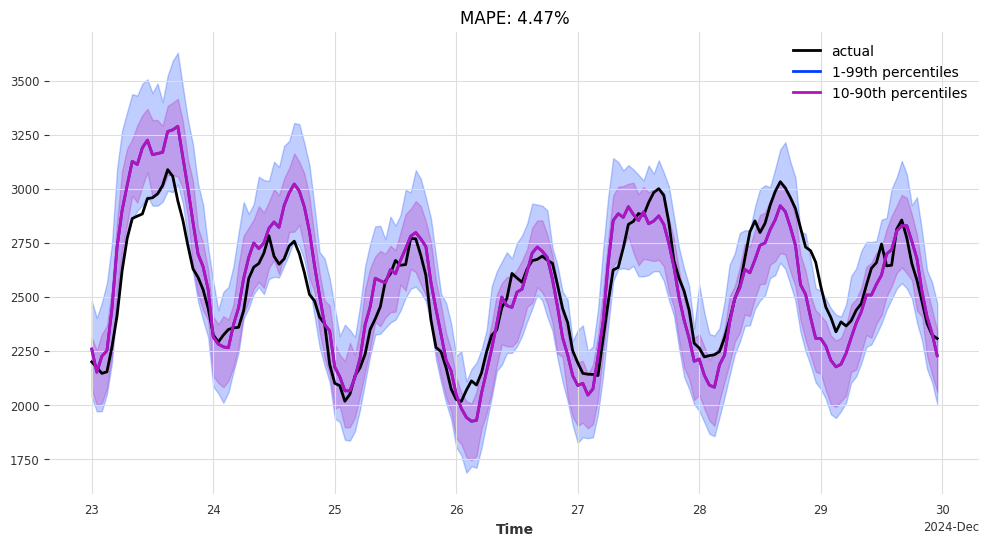

In [32]:
# plot actual series
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
test[: train_inv.end_time()].plot(label="actual")
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"
# plot prediction with quantile ranges
forecast_inv.plot(
    low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
)
forecast_inv.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

plt.title(f"MAPE: {mape(test, forecast_inv):.2f}%")
plt.legend()


In [33]:
print(past_covariates_transformed.components)
print(future_covariates_transformed.components)

Index(['Temperature', 'Humidity', 'Solar', 'is_holiday', 'hour', 'lag_temp_1',
       'lag_humid_1', 'lag_solar_1', 'lag_temp_2', 'lag_humid_2',
       'lag_solar_2', 'lag_temp_3', 'lag_humid_3', 'lag_solar_3', 'lag_temp_6',
       'lag_humid_6', 'lag_solar_6', 'lag_temp_12', 'lag_humid_12',
       'lag_solar_12', 'lag_temp_24', 'lag_humid_24', 'lag_solar_24', 'lag_24',
       'lag_48', 'lag_72', 'lag_96', 'lag_120', 'lag_144', 'lag_168'],
      dtype='object', name='component')
Index(['Temperature', 'Humidity', 'Solar', 'is_holiday', 'hour'], dtype='object', name='component')


In [34]:
from darts.explainability.tft_explainer import TFTExplainer
%matplotlib qt

explainer = TFTExplainer(my_model)  # requires `background` if model was trained on multiple series
results = explainer.explain()
# plot the results
explainer.plot_attention(results, plot_type="all")
explainer.plot_variable_selection(results)

ImportError: Failed to import any of the following Qt binding modules: PyQt6, PySide6, PyQt5, PySide2